# Contents
1. open csv, merge, check and remove duplicates
2. ensure the right chats were scraped
3. check for and remove duplicates and NA in text column
4. remove chats that are not part of Querdenken community (mainstream media)
5. apply classification of party, media, movement
6. create message_id
7. check user/chats relation per category of chat, remove duplicate channels due to case sensitivity
8. investigate hashtags
9. check datetime, create cutoff point (1 Jan 2020)
10. check views
11. preparing edgelist for network analysis
12. dropping unnecessary columns, create 'text_clean'
13. clean text with script (URL, lowercase, special characters)
14. create subset and remove barely seen messages
15. remove very short messages
16. investigate short messages and grouping possibilities
17. save new df_textanal_short to csv

**end**

### step 1: Open csv, merge, check and remove duplicates
from the three iterations of scraping (s1,s2,s3), the output csv are merged and checked for duplicate rows

In [3]:
import pandas as pd

# Paths to your CSV files
csv_file_paths = ['output_s1.csv', 'output_s2.csv', 'output_s3_t5.csv']

# Read the CSV files into DataFrames
df1 = pd.read_csv(csv_file_paths[0])
df2 = pd.read_csv(csv_file_paths[1])
df3 = pd.read_csv(csv_file_paths[2])

# 1. Check if all column names of the three CSVs are identical
columns_identical = (df1.columns == df2.columns).all() and (df2.columns == df3.columns).all()

# 2. See how many rows each CSV has
rows_df1 = len(df1)
rows_df2 = len(df2)
rows_df3 = len(df3)

# 3. Merge the three df into a new one called 'merged_df'
merged_df = pd.concat([df1, df2, df3], ignore_index=True)

# 4. Check if there are rows that are identical (duplicates) in the new csv
duplicates_in_merged = merged_df.duplicated().any()

# Output the results
print(f"Are all column names identical across the three CSVs? {columns_identical}")
print(f"Number of rows in CSV 1: {rows_df1}")
print(f"Number of rows in CSV 2: {rows_df2}")
print(f"Number of rows in CSV 3: {rows_df3}")
print(f"Are there any duplicate rows in 'output_final_t5.csv'? {duplicates_in_merged}")

/tmp/ipykernel_22761/2308577808.py:9: DtypeWarning: Columns (9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv(csv_file_paths[2])


Are all column names identical across the three CSVs? True
Number of rows in CSV 1: 84470
Number of rows in CSV 2: 125599
Number of rows in CSV 3: 1558797
Are there any duplicate rows in 'output_final_t5.csv'? True


In [6]:
number_of_duplicates = merged_df.duplicated(keep='first').sum()
print(f"Number of duplicate rows: {number_of_duplicates}")
merged_df = merged_df.drop_duplicates()
print("duplicate rows have been removed")

Number of duplicate rows: 0
duplicate rows have been removed


Now check for duplicates in 'link_to_message' column

In [10]:
duplicates = merged_df.duplicated(subset='link_to_message', keep=False)

# Counting the number of duplicates
number_of_duplicates = duplicates.sum()

# Printing the number of duplicates
print(f"Number of duplicate entries in 'link_to_message': {number_of_duplicates}")

Number of duplicate entries in 'link_to_message': 306047


In [12]:
merged_df = merged_df.drop_duplicates(subset= "link_to_message", keep='first')
duplicates = merged_df.duplicated(subset='link_to_message', keep=False)

# Counting the number of duplicates
number_of_duplicates = duplicates.sum()

# Printing the number of duplicates
print(f"Number of duplicate entries in 'link_to_message': {number_of_duplicates}")

Number of duplicate entries in 'link_to_message': 0


now the dataframe merged_df does not contain duplicate messages. The text of some messages may still be identical, but messages that were scraped multiple times (in the different seeds) have been removed (through removing duplicates of the unique links to the messages).

### step 2: check that only chats from the seeds were scraped
qualitative assessment of those that are not from seeds: Retain y/n

In [13]:
print(merged_df.columns.tolist())

['channel_name', 'link_to_message', 'could_be_displayed', 'user', 'user_link', 'user_img', 'text', 'nb_hashtags', 'hashtags', 'is_reply_img', 'is_reply_user', 'is_reply_text', 'stickers', 'nb_photos', 'photos', 'nb_videos', 'videos', 'videos_times', 'nb_links', 'links', 'link_img', 'link_site', 'link_title', 'link_description', 'views', 'datetime', 'edited']


In [15]:
# Load channel names from the first .txt file
with open('/home/onyxia/work/new/seeds/seed2.txt', 'r') as file:
    channels_list_1 = [line.strip() for line in file]

# Load channel names from the second .txt file
with open('/home/onyxia/work/new/seeds/seed3_t5.txt', 'r') as file:
    channels_list_2 = [line.strip() for line in file]
combined_channel_list = list(set(channels_list_1 + channels_list_2))
unmatched_channels = merged_df[~merged_df['channel_name'].isin(combined_channel_list)]
print("Unmatched channel names:")
print(unmatched_channels['channel_name'].unique())

Unmatched channel names:
['BuendnisTH' 'dieBasisST' 'Basisradio' 'BayrischeFreiheitsboten'
 'diebasis_chemnitz' 'democracy_app' 'berlin080922' 'dieBasis_OWL'
 'Info_dieBasis_LV_SL' 'AuroraCaeliPodcast' 'dieBasis_Posts'
 'vorstand_dieBasis' 'friedensbewegung_bundesweit' 'dieBasis_SiWi'
 'Samueleckert' 'QUERDENKEN']


Qualitative Assessment of the Chats: belong the movement/party. So they will be kept.

### step 3: check for and remove duplicates and NA in text column

In [63]:
#1 remove na in text column
# Count rows where 'text' is NA
na_count = merged_df['text'].isna().sum()
print(f"Number of rows with NA in 'text' column: {na_count}")

# Remove rows where 'text' is NA
df_clean = merged_df.dropna(subset=['text']).copy()

# Verify removal
print(f"Number of rows after removing NAs: {len(df_clean)}")

Number of rows with NA in 'text' column: 84637
Number of rows after removing NAs: 1508159


### step 4: remove chats from mainstream media

In [64]:
#3. remove what is not part of Querdenken - check for keywords of mainstream media or main parties in 'channel_name'
media_keywords = [
    "ARD", "ZDF", "Deutschlandfunk", "NDR", "WDR", 
    "SWR", "BR", "MDR", "rbb", "DW", 
    "Die Zeit", "FAZ", "Frankfurter Allgemeine", "Süddeutsche Zeitung", 
    "Der Spiegel", "Stern", "Focus", "Bild", "SPD", "FDP", "CDU", "AFD", "Linke", "Grüne"
]

media_keywords_lower = [keyword.lower() for keyword in media_keywords]

def contains_media_keyword(channel_name):
    channel_name_lower = channel_name.lower() if isinstance(channel_name, str) else ""
    return any(keyword in channel_name_lower for keyword in media_keywords_lower)
    
media_related_channel_names = [channel for channel in df_clean['channel_name'] if contains_media_keyword(channel)]

media_related_channel_names_unique = list(set(media_related_channel_names))

print("Unique channel names containing keywords related to German mainstream media:")
for channel in media_related_channel_names_unique:
    print(channel)

Unique channel names containing keywords related to German mainstream media:
freielinke
LeuchtturmARD
Freie_Brandenburger_official
steuerzahler_rene_quarda
paulbrandenburg
freie_brandenburger
sandradoornbos
BrandenburgTVinfo
swd_hardcore
berlinmarkbrandenburg
RA_Ludwig
die_basis_brandenburg
RA_ludwig
grundrechte_jetzt
sabrinakollmorgen
Brandenburger_Freiheit
Verfassungsschutz_BRD
Klardenker_Kanal
SandraGabriel269
Bauern_Verbraucher_geeint_Kanal
freies_bremen
politische_bildersprueche
basisdemokratie_bremen
StimmeFreiesBrandenburg
agfriedenbremen


no mainstream media channels detected based on keywords

### step 5: apply classification of media/movement/party

In [116]:
#categorise channels into party, movement, media
import pandas as pd

# Sample DataFrame creation (replace this with your actual df_clean DataFrame)
# df_clean = pd.DataFrame({
#     'channel_name': ['basisSomething', 'InfoMediaChannel', 'TVChannel', 'MixedBasisTV']
# })

# Initialize 'channel_category' with default value 0
df_clean['channel_category'] = 0

# Function to categorize channel based on 'channel_name'
def categorize_channel(channel_name):
    channel_name_lower = channel_name.lower()
    if 'basis' in channel_name_lower:
        return 'party'
    elif any(keyword in channel_name_lower for keyword in ['tv', 'info', 'media', 'news', 'magazin']):
        return 'media'
    return 'movement'  # Return 'movement'

# Apply the categorization function to the 'channel_name' column
df_clean['channel_category'] = df_clean['channel_name'].apply(categorize_channel)

# Display the DataFrame to verify the new 'channel_category' column
print(df_clean)

         message_id     channel_name channel_category  \
0                 0  die_basis_funkt            party   
1                 1  die_basis_funkt            party   
3                 3  die_basis_funkt            party   
4                 4  die_basis_funkt            party   
5                 5  die_basis_funkt            party   
...             ...              ...              ...   
1768861     1768861           bustek         movement   
1768862     1768862           bustek         movement   
1768863     1768863           bustek         movement   
1768864     1768864           bustek         movement   
1768865     1768865           bustek         movement   

                                                      text  \
0                             https://t.me/die_basis_funkt   
1        10 Bundesländer - 44 Gründungsmitglieder - 4. ...   
3                                    Channel photo updated   
4                             https://youtu.be/qmTC-R8hE6E   
5    

### step 6: add message_id

In [66]:
#create id for each message
df_clean['message_id'] = df_clean.index

### step 7: check user/chats relation per category of chat

In [67]:
#5 user column
unique_users = df_clean['user'].nunique()
print(f"Number of unique users: {unique_users}")

# Count how many messages each user sent
messages_per_user = df_clean['user'].value_counts()

print("Messages sent per user (top users):")
print(messages_per_user.head())

Number of unique users: 478
Messages sent per user (top users):
user
Gesund ohne Medikament                                                                                                     59341
Uncut-News.ch "Das Original"🇨🇭Unabhängige Analysen und Informationen zu Geopolitik, Wirtschaft, Gesundheit, Technologie    58235
Wirtschaftsnachrichten - Börse - Finanzen - Währungen - Devisen                                                            57237
Epoch Times Deutsch                                                                                                        51785
Corona-Reset - Lock Down The Lockdown - Gewinne in Deiner Corona-Situation                                                 35858
Name: count, dtype: int64


In [69]:
matches = df_clean[df_clean['channel_name'] == df_clean['user']]
matches_count = len(matches)
print(f"Number of cases where 'channel_name' equals 'user': {matches_count}")
matches = df_clean[df_clean['channel_name'] == df_clean['user']]
matches_count_per_category = matches.groupby('channel_category').size()
print(matches_count_per_category)

Number of cases where 'channel_name' equals 'user': 105599
channel_category
0        104098
media      1501
dtype: int64


In [71]:
partei_users = set(df_clean[df_clean['channel_category'] == 'Partei']['user'].unique())
media_users = set(df_clean[df_clean['channel_category'] == 'Media']['user'].unique())
other_users = set(df_clean[df_clean['channel_category'] == '0']['user'].unique())
# Identify overlaps between each pair of categories
overlap_partei_media = partei_users.intersection(media_users)
overlap_partei_other = partei_users.intersection(other_users)
overlap_media_other = media_users.intersection(other_users)

# Identify users present in all three categories
overlap_all_three = partei_users.intersection(media_users, other_users)
print(f"Overlap between three categories {overlap_all_three}")
print(f"Overlap between Partei and media {overlap_partei_media}")
print(f"Overlap between Partei and Movement {overlap_partei_other}")
print(f"Overlap between Media and Movement {overlap_media_other}")

Overlap between three categories set()
Overlap between Partei and media set()
Overlap between Partei and Movement set()
Overlap between Media and Movement set()


In [75]:
#clean how many channels have been mentioned multiple times due to different capitalisations
df_clean['channel_name_lower'] = df_clean['channel_name'].str.lower()

# Count the unique, case-insensitive 'channel_name' occurrences
unique_channels_case_insensitive = df_clean['channel_name_lower'].nunique()

# Count the original, case-sensitive 'channel_name' occurrences
unique_channels_case_sensitive = df_clean['channel_name'].nunique()

# Calculate the difference to see how many are affected by case sensitivity
difference = unique_channels_case_sensitive - unique_channels_case_insensitive

print(f"Unique channels (case-sensitive): {unique_channels_case_sensitive}")
print(f"Unique channels (case-insensitive): {unique_channels_case_insensitive}")
print(f"Number of channels affected by case sensitivity: {difference}")
# Group by the lowercase channel name and count the unique case-sensitive names for each
channels_with_multiple_capitalizations = df_clean.groupby('channel_name_lower')['channel_name'].nunique()

# Filter for groups with more than one unique case-sensitive name
channels_with_multiple_capitalizations = channels_with_multiple_capitalizations[channels_with_multiple_capitalizations > 1]

print(f"Channels with multiple capitalizations: {len(channels_with_multiple_capitalizations)}")
print(channels_with_multiple_capitalizations)

Unique channels (case-sensitive): 485
Unique channels (case-insensitive): 477
Number of channels affected by case sensitivity: 8
Channels with multiple capitalizations: 8
channel_name_lower
anwaelte_fuer_aufklaerung    2
coronatransition             2
diebasisst                   2
freiesst                     2
mitteldeutschlandtv          2
ra_ludwig                    2
rosenbusch                   2
saschaschmitztv              2
Name: channel_name, dtype: int64


In [77]:
# Make 'channel_name' and 'user' lowercase
df_clean['channel_name_lower'] = df_clean['channel_name'].str.lower()
df_clean['user_lower'] = df_clean['user'].str.lower()

# Count unique values in the original and lowercase columns for 'user'
unique_users_case_sensitive = df_clean['user'].nunique()
unique_users_case_insensitive = df_clean['user_lower'].nunique()

# Calculate the difference to see how many are affected by case sensitivity for 'user'
difference_users = unique_users_case_sensitive - unique_users_case_insensitive

print(f"Unique users (case-sensitive): {unique_users_case_sensitive}")
print(f"Unique users (case-insensitive): {unique_users_case_insensitive}")
print(f"Number of users affected by case sensitivity: {difference_users}")

# Drop the original 'channel_name' and 'user' columns
df_clean = df_clean.drop(['channel_name', 'user'], axis=1)

# Rename the lowercase columns to the original column names
df_clean = df_clean.rename(columns={'channel_name_lower': 'channel_name', 'user_lower': 'user'})


Unique users (case-sensitive): 478
Unique users (case-insensitive): 478
Number of users affected by case sensitivity: 0


In [78]:
print(df_clean.columns.tolist())

['link_to_message', 'could_be_displayed', 'user_link', 'user_img', 'text', 'nb_hashtags', 'hashtags', 'is_reply_img', 'is_reply_user', 'is_reply_text', 'stickers', 'nb_photos', 'photos', 'nb_videos', 'videos', 'videos_times', 'nb_links', 'links', 'link_img', 'link_site', 'link_title', 'link_description', 'views', 'datetime', 'edited', 'channel_category', 'message_id', 'channel_name', 'user']


### step 8: investigate hashtags

In [79]:
#check hashtags
temp_df = (df_clean.dropna(subset=['hashtags'])
           .assign(individual_hashtags=lambda x: x['hashtags'].str.split(','))
           .explode('individual_hashtags'))

# Clean up individual hashtags: strip whitespace and convert to lowercase
temp_df['individual_hashtags'] = temp_df['individual_hashtags'].str.strip().str.lower()

# Group by 'channel_category' and 'individual_hashtags' and count frequencies
hashtag_counts = (temp_df.groupby(['channel_category', 'individual_hashtags'])
                  .size()
                  .reset_index(name='count'))

# Step 3: Sort within each 'channel_category' to identify the most frequent hashtags
sorted_hashtag_counts = hashtag_counts.sort_values(by=['channel_category', 'count'], ascending=[True, False])

# display top N hashtags for each category
top_n = 5
top_hashtags_by_category = sorted_hashtag_counts.groupby('channel_category').head(top_n)

print(top_hashtags_by_category)

      channel_category                                individual_hashtags  \
44231                0                     tipp|mustread|topthema|aktuell   
19505                0  gesundheit|heilmethoden|alternativemedizin|ern...   
46263                0                     videonews|audionews|interviews   
1407                 0                                  allgemein|aktuell   
23180                0                                            hinweis   
57545            media                                           netzfund   
59509            media                                             shorts   
55652            media                                         kingthomas   
52999            media                         fairtalk|aufaugenh%c3%b6he   
60154            media                                         teamheimat   
62593            party                                           diebasis   
65179            party  menschheitsfamilie|machtbegrenzung|diebasis|sc...   

### step 9: check time window and generate cutoff point (1 Jan 2020)

In [80]:
#check time window
df_clean['datetime'] = pd.to_datetime(df_clean['datetime'])

min_datetime = df_clean['datetime'].min()
max_datetime = df_clean['datetime'].max()

print(f"Earliest datetime in the dataset: {min_datetime}")
print(f"Latest datetime in the dataset: {max_datetime}")

Earliest datetime in the dataset: 2018-01-08 08:38:00+00:00
Latest datetime in the dataset: 2024-03-03 09:08:54+00:00


In [81]:
cutoff_datetime = pd.Timestamp('2020-03-01', tz='UTC')

# Now you can safely compare and count messages sent before March 2020
messages_before_march_2020 = df_clean[df_clean['datetime'] < cutoff_datetime].shape[0]

print(f"Number of messages sent before March 2020: {messages_before_march_2020}")


Number of messages sent before March 2020: 94655


In [82]:
cutoff_datetime_jan_2020 = pd.Timestamp('2020-01-01', tz='UTC')

# Keep only messages on or after January 2020
df_clean = df_clean[df_clean['datetime'] >= cutoff_datetime_jan_2020]

In [83]:
#check all went well
min_datetime = df_clean['datetime'].min()
max_datetime = df_clean['datetime'].max()

print(f"Earliest datetime in the dataset: {min_datetime}")
print(f"Latest datetime in the dataset: {max_datetime}")

Earliest datetime in the dataset: 2020-01-01 01:43:58+00:00
Latest datetime in the dataset: 2024-03-03 09:08:54+00:00


### step 10: inspect views and create thresholds

In [84]:
# Updated thresholds and labels to match the desired ranges
thresholds = [100000, 10000, 1000, 100, 10]
threshold_labels = ['100000>', '10000-99999', '1000-9999', '100-999', '10-99']

# Updated function to categorize views into thresholds
def categorize_views(views):
    if views > 100000:
        return '100000>'
    elif views > 10000:
        return '10000-99999'
    elif views > 1000:
        return '1000-9999'
    elif views > 100:
        return '100-999'
    elif views > 10:
        return '10-99'
    else:
        return '0-10'

# Apply the updated categorization function to the 'views' column
df_clean['view_threshold'] = df_clean['views'].apply(categorize_views)

### step 11: create edgelist for network analysis; 
both edgelist(containing all connections even to chats outside the community, and edgelist_clean which replaces chats not in the community with 'other_chats'

In [85]:
print(df_clean.columns.tolist())

['link_to_message', 'could_be_displayed', 'user_link', 'user_img', 'text', 'nb_hashtags', 'hashtags', 'is_reply_img', 'is_reply_user', 'is_reply_text', 'stickers', 'nb_photos', 'photos', 'nb_videos', 'videos', 'videos_times', 'nb_links', 'links', 'link_img', 'link_site', 'link_title', 'link_description', 'views', 'datetime', 'edited', 'channel_category', 'message_id', 'channel_name', 'user', 'view_threshold']


In [86]:
# gephi df_network as csv with the cleaned datafile
import re
df_network = df_clean[['channel_name', 'links', 'channel_category']].copy()
def extract_valid_telegram_username(link_text):
    # Ensure input is a string
    if not isinstance(link_text, str):
        return None
    # Define the pattern for extracting Telegram usernames
    telegram_pattern = re.compile(r'(?:https?://)?t\.me/([\w\d_-]+)')
    # Search for all occurrences of the pattern
    matches = telegram_pattern.findall(link_text)
    # Filter out any non-Telegram links or invalid entries
    valid_usernames = [match for match in matches if not any(ext in match for ext in ['http', 'https', '|'])]
    # Return the first valid Telegram username, if available
    return valid_usernames[0] if valid_usernames else None

# Apply the refined function to extract valid Telegram usernames
df_network['links'] = df_network['links'].apply(extract_valid_telegram_username)
df_network['links'] = df_network['links'].str.lower()

# Drop rows without a valid Telegram username
df_network = df_network.dropna(subset=['links'])
df_network = df_network.dropna(subset=['channel_name'])
df_network = df_network.dropna(subset=['channel_category'])

contains_floats = df_network['links'].apply(lambda x: isinstance(x, float)).any()

if contains_floats:
    print("The column contains float values.")
    df_network = df_network[~df_network['links'].apply(lambda x: isinstance(x, float))]
else:
    print("No float values in 'links'.")

# create edgelist for copy
edgelist = df_network.copy()
edgelist['source'] = edgelist['channel_name'].str.lower()
edgelist['target'] = edgelist['links'].str.lower()
edgelist['channel_category'] = edgelist['channel_category'].str.lower()

edgelist = edgelist.drop('channel_name', axis=1)
edgelist = edgelist.drop('links', axis=1)
# Display the first few rows of edgelist to verify
print(edgelist.head())
len(edgelist)


No float values in 'links'.
   channel_category           source                    target
0             party  die_basis_funkt           die_basis_funkt
6             party  die_basis_funkt      henning_basis_berlin
7             party  die_basis_funkt          diebasisnrwfunkt
10            party  die_basis_funkt  diebasis_infoszuumfragen
15            party  die_basis_funkt                  diebasis


862824

In [ ]:
import pandas as pd

# Step 1: Read the text file, convert to lowercase, and split into a list
with open('/path/to/seed3_t5.txt', 'r') as file:
    valid_targets = file.read().lower().splitlines()

# Step 2: Copy edgelist to edgelist_clean and convert 'target' in edgelist_clean to lowercase for comparison
edgelist_clean = edgelist.copy()
edgelist_clean['target'] = edgelist_clean['target'].str.lower()

# Step 3: Replace values in 'target' that are not in valid_targets with 'other_chats'
edgelist_clean['target'] = edgelist_clean['target'].apply(lambda x: x if x in valid_targets else 'other_chats')

# Note: Convert 'target' back to its original case if needed here

# Step 4: Your edgelist_clean is ready

In [87]:
edgelist_clean.to_csv("path/to/edgelist_clean_v2.csv", index=False)
edgelist.to_csv("path/to/edgelist_v2.csv", index=False)

edgelist has been created. NA will continue in gephi

### step 12: drop unnecessary columns, create 'text_clean'

In [88]:
print(df_clean.columns.tolist())

['link_to_message', 'could_be_displayed', 'user_link', 'user_img', 'text', 'nb_hashtags', 'hashtags', 'is_reply_img', 'is_reply_user', 'is_reply_text', 'stickers', 'nb_photos', 'photos', 'nb_videos', 'videos', 'videos_times', 'nb_links', 'links', 'link_img', 'link_site', 'link_title', 'link_description', 'views', 'datetime', 'edited', 'channel_category', 'message_id', 'channel_name', 'user', 'view_threshold']


In [91]:
# Columns to be dropped
columns_to_drop = [
    'user_img', 'nb_hashtags', 'hashtags', 
    'is_reply_img', 'is_reply_user', 'is_reply_text', 
    'stickers', 'nb_photos', 'photos', 
    'nb_videos', 'videos', 'videos_times', 
    'link_img', 'link_site', 'link_title', 'link_description', 
    'edited'
]
# Dropping the specified columns from df_clean
df_clean = df_clean.drop(columns=columns_to_drop)

# Displaying the first few rows to verify the columns have been dropped
print(df_clean.head())

KeyError: "['user_img', 'nb_hashtags', 'hashtags', 'is_reply_img', 'is_reply_user', 'is_reply_text', 'stickers', 'nb_photos', 'photos', 'nb_videos', 'videos', 'videos_times', 'link_img', 'link_site', 'link_title', 'link_description', 'edited'] not found in axis"

In [92]:
print(df_clean.columns.tolist())

['link_to_message', 'could_be_displayed', 'user_link', 'text', 'nb_links', 'links', 'views', 'datetime', 'channel_category', 'message_id', 'channel_name', 'user', 'view_threshold']


In [94]:
df_clean['text_clean'] = df_clean['text']
print(df_clean.columns.tolist())

['link_to_message', 'could_be_displayed', 'user_link', 'text', 'nb_links', 'links', 'views', 'datetime', 'channel_category', 'message_id', 'channel_name', 'user', 'view_threshold', 'text_clean']


In [95]:
new_order = [
    'message_id', 'channel_name', 'channel_category', 
    'text', 'text_clean', 'views', 'view_threshold', 
    'datetime'
]

# Adding the remaining columns to the new order, ensuring no column is dropped
remaining_columns = [col for col in df_clean.columns if col not in new_order]
new_order += remaining_columns

# Reassigning the columns of df_clean based on the new order
df_clean = df_clean[new_order]


In [96]:
print(df_clean.columns.tolist())

['message_id', 'channel_name', 'channel_category', 'text', 'text_clean', 'views', 'view_threshold', 'datetime', 'link_to_message', 'could_be_displayed', 'user_link', 'nb_links', 'links', 'user']


### step 13: clean text with script

the script removes "..." multiple periods, converts to lowercase, removes URLs

In [99]:
import sys
sys.path.append('path/to/scripts')
from text_broom import text_broom
from text_broom_chill import text_broom_chill
# Apply text_broom_chill to text_notsoclean
df_clean['text_clean'] = df_clean['text_clean'].apply(text_broom_chill)

/home/onyxia/work/new/scripts/text_broom_chill.py:9: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()


### step 14: create subset for further + remove barely seen messages

In [105]:
# save old cleaned datafile 'df_clean' for future reference
df_clean.to_csv("path/to/big_csv_20March.csv", index=False)

In [120]:
#new dataframe df_textanal for BERT
df_textanal = df_clean
df_textanal['channel_category'] = df_textanal['channel_category'].str.strip()

In [121]:
unique_values_count = df_textanal['view_threshold'].value_counts()

# Find out how this distribution is different for the three categories in 'channel_category'
category_distribution = df_textanal.groupby('channel_category')['view_threshold'].value_counts().unstack(fill_value=0)

(unique_values_count, category_distribution)

(view_threshold
 1000-9999      534542
 10000-99999    363533
 100-999        332794
 10-99          152562
 100000>         32438
 0-10            17127
 Name: count, dtype: int64,
 view_threshold     0-10   10-99  100-999  1000-9999  10000-99999  100000>
 channel_category                                                         
 media                60   19138    21260      23400        51313     6890
 movement          17009  125248   298304     507242       310974    25500
 party                58    8176    13230       3900         1246       48)

In [122]:
distribution_percent = category_distribution.div(category_distribution.sum(axis=1), axis=0) * 100

distribution_percent

view_threshold,0-10,10-99,100-999,1000-9999,10000-99999,100000>
channel_category,,,,,,
media,0.049156,15.679046,17.417521,19.170742,42.038817,5.644719
movement,1.324403,9.752413,23.227388,39.496308,24.213935,1.985553
party,0.217571,30.669968,49.628629,14.629755,4.674019,0.180059


For party chat messages(channel_category=party), ca. 50% were viewed by between 100 and 1000 people. another 30% were viewed by 10-100 people. Only 5% were viewed by more than 10.000 people.

For media chat messages, (channel_category=media), ca. 50% were seen by more than 10.000 people. 15% by >100 and another 15% by less than 100.

For Community chat messages, (channel_category=movement), 30% were seen by >10.000 people, 30% by more than 10.000 people, 25% by 100-10.000 people.

I would suggest dropping all messages <100 views from movement and media chats.

In [126]:
# Keep rows that satisfy one of the following conditions:
# 1. The channel_category is 'party'
# 2. The channel_category is 'movement' or 'media', but views are 100 or more
df_textanal_short = df_textanal[
    (df_textanal['channel_category'] == 'party') |
    ((df_textanal['channel_category'].isin(['movement', 'media'])) & (df_textanal['views'] >= 100))
]

In [127]:
# Calculate the number of rows in the original DataFrame
original_row_count = len(df_textanal)

# Calculate the number of rows in the filtered DataFrame
filtered_row_count = len(df_textanal_short)

# Calculate the number of rows dropped
rows_dropped = original_row_count - filtered_row_count

# Print the result
print(f"Number of rows dropped: {rows_dropped}")


Number of rows dropped: 160896


### step 15: remove very short messages
check distribution of message length and then decide which messages to retain. Goal: greater uniformity for BERTopic

In [130]:
contains_floats = df_textanal['text_clean'].apply(lambda x: isinstance(x, float)).any()

if contains_floats:
    print("The column contains float values.")
    df_textanal = df_textanal[~df_textanal['text_clean'].apply(lambda x: isinstance(x, float))]
else:
    print("No float values in 'text_clean'.")
contains_floats = df_textanal_short['text_clean'].apply(lambda x: isinstance(x, float)).any()

if contains_floats:
    print("The column contains float values.")
    df_textanal_short = df_textanal_short[~df_textanal['text_clean'].apply(lambda x: isinstance(x, float))]
else:
    print("No float values in 'text_clean'.")


No float values in 'text_clean'.
No float values in 'text_clean'.


In [131]:
import pandas as pd

# Assuming df_textanal_short exists and has a column 'text_lowernopunct'
word_counts_per_cell = df_textanal_short['text_clean'].apply(lambda x: len(x.split()))

bins = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 130, 150, 170, 200, 250, float('inf')]
labels = ['<5', '6-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '111-130', '131-150', '151-170', '171-200', '201-250', '251+']

word_count_categories = pd.cut(word_counts_per_cell, bins=bins, labels=labels, right=False)
word_count_distribution = word_count_categories.value_counts().sort_index()

print(word_count_distribution)


text_clean
<5         153643
6-10        90639
11-20      200243
21-30      131178
31-40      114027
41-50       99700
51-60       76506
61-70       61397
71-80       48347
81-90       41849
91-100      37168
101-110     34135
111-130     64736
131-150     39171
151-170     16592
171-200     15549
201-250     17547
251+        29673
Name: count, dtype: int64


In [132]:
import pandas as pd

# Define bins and labels
bins = [0, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 130, 150, 170, 200, 250, float('inf')]
labels = ['<5', '6-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100', '101-110', '111-130', '131-150', '151-170', '171-200', '201-250', '251+']

categories = ["media", "movement", "party"]

results = {}

for category in categories:
    # Filter the DataFrame for the current channel_category
    df_subset = df_textanal_short[df_textanal_short['channel_category'] == category]
    
    # Calculate word count distribution for the subset
    word_counts_per_cell = df_subset['text_clean'].apply(lambda x: len(x.split()))
    word_count_categories = pd.cut(word_counts_per_cell, bins=bins, labels=labels, right=False)
    word_count_distribution = word_count_categories.value_counts().sort_index()
    
    # Store results
    results[category] = word_count_distribution

# Now, results contains the word count distributions for each channel_category subset
for category, distribution in results.items():
    print(f"Channel Category: {category}")
    print(distribution, "\n")


Channel Category: media
text_clean
<5          8268
6-10       11048
11-20      20204
21-30      10496
31-40       7472
41-50       6241
51-60       5812
61-70       4915
71-80       4510
81-90       3898
91-100      3381
101-110     2852
111-130     4561
131-150     2856
151-170     1301
171-200     1237
201-250     1548
251+        2453
Name: count, dtype: int64 

Channel Category: movement
text_clean
<5         142126
6-10        78085
11-20      177170
21-30      118469
31-40      104173
41-50       91527
51-60       69127
61-70       55271
71-80       42798
81-90       37041
91-100      32849
101-110     30362
111-130     58084
131-150     35181
151-170     14672
171-200     13631
201-250     15382
251+        26441
Name: count, dtype: int64 

Channel Category: party
text_clean
<5         3249
6-10       1506
11-20      2869
21-30      2213
31-40      2382
41-50      1932
51-60      1567
61-70      1211
71-80      1039
81-90       910
91-100      938
101-110     921
111-130    209

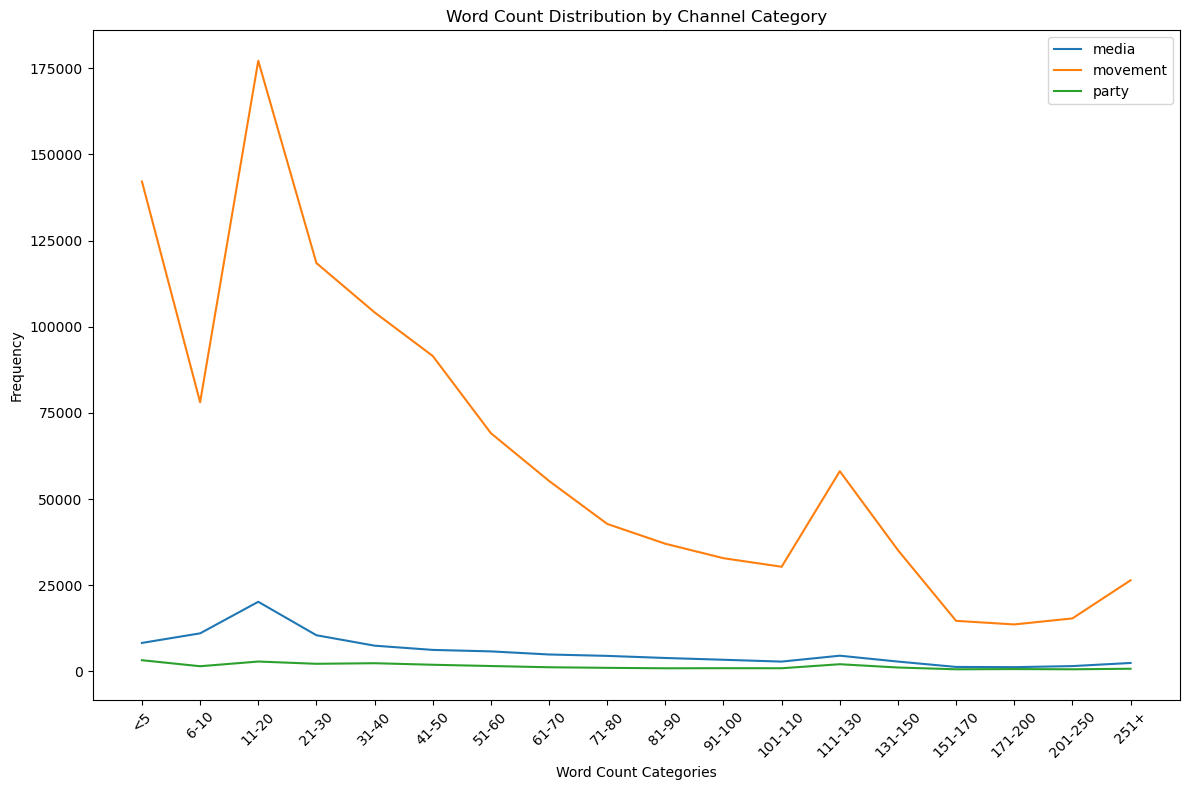

In [133]:
#for better visualisation: 
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
for category, distribution in results.items():
    plt.plot(distribution.index, distribution.values, label=category)

# Add labels and legend
plt.title('Word Count Distribution by Channel Category')
plt.xlabel('Word Count Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.legend()
plt.tight_layout()  # Adjust layout to prevent overlap of labels
plt.show()

In [153]:
df_textanal_short['word_count'] = df_textanal_short['text_clean'].apply(lambda x: len(x.split()))

# Filter the DataFrame for rows where the number of words is less than 10
df_less_than_10_words = df_textanal_short[df_textanal_short['word_count'] < 5]

/tmp/ipykernel_22761/3564217042.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_textanal_short['word_count'] = df_textanal_short['text_clean'].apply(lambda x: len(x.split()))


In [154]:
random_samples = df_less_than_10_words.sample(n=5)

pd.set_option('display.max_colwidth', None)
# Display the sampled rows
print(random_samples[['text_clean']])

                      text_clean
51792    .und aktuell in london 
395857           t.me/rosenbusch
1257596                         
356473                          
987936               00971 #link


may of the very short messages are currently na, which will be removed at a later stage.Those with less than 10 words are often quite meaningful. <5 words are not meaningful and can be removed right away from df_textanal_short.

In [156]:
df_textanal_short = df_textanal_short[df_textanal_short['word_count'] >= 5]
print(len(df_textanal))
print(len(df_textanal_short))

1432996
1118457


### step 16: check if messages can be grouped together

In [157]:
df_textanal_short['datetime'] = pd.to_datetime(df_textanal_short['datetime'])

# Sort the DataFrame by 'channel_name' and 'datetime'
df_textanal_short.sort_values(by=['channel_name', 'datetime'], inplace=True)
# Convert 'datetime' to just the date and time (without timezone) if not already
df_textanal_short['datetime'] = df_textanal_short['datetime'].dt.tz_localize(None)

# Initialize the 'thread' column with None or an appropriate default value
df_textanal_short['thread'] = None



/tmp/ipykernel_22761/1105508565.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['datetime'] = pd.to_datetime(df_filtered['datetime'])
/tmp/ipykernel_22761/1105508565.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.sort_values(by=['channel_name', 'datetime'], inplace=True)
/tmp/ipykernel_22761/1105508565.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

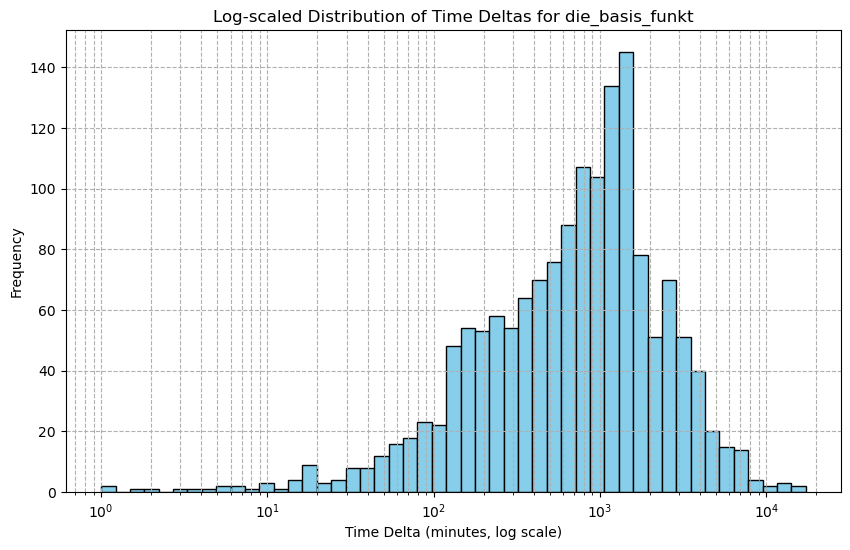

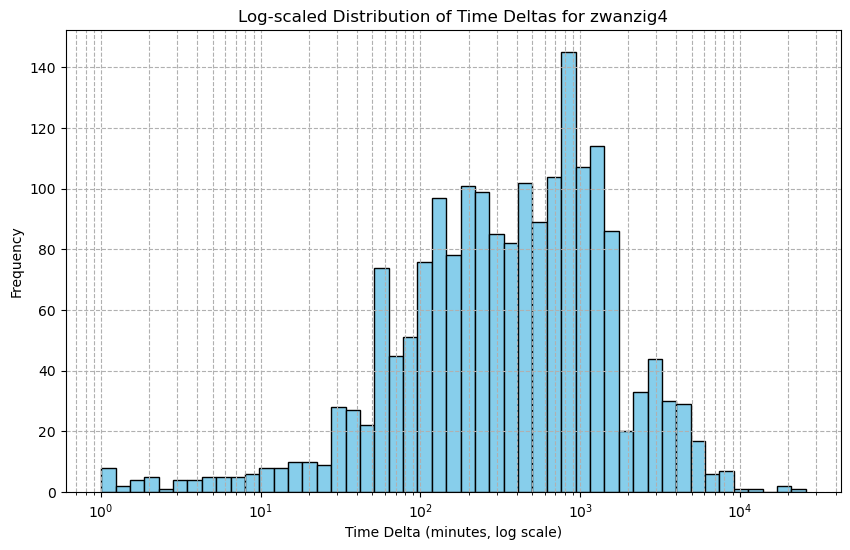

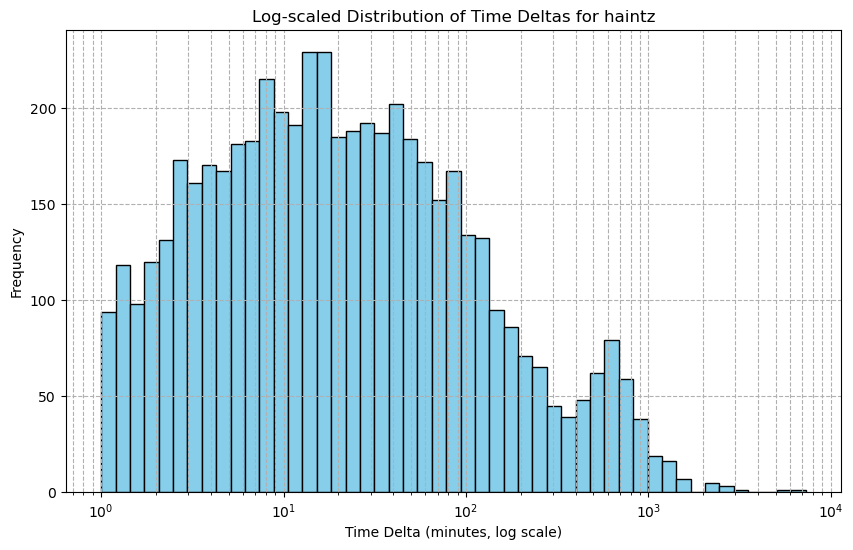

In [159]:
#now see average distance between messages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame for the channels of interest
channels_of_interest = ['die_basis_funkt', 'zwanzig4', 'haintz']
df_filtered = df_textanal_short[df_textanal_short['channel_name'].isin(channels_of_interest)]

# Ensure datetime is in the correct format and sorted
df_filtered['datetime'] = pd.to_datetime(df_filtered['datetime'])
df_filtered.sort_values(by=['channel_name', 'datetime'], inplace=True)

# Calculate time deltas within each channel
df_filtered['time_delta'] = df_filtered.groupby('channel_name')['datetime'].diff().dt.total_seconds() / 60  # delta in minutes

# Visualizing the distribution of time deltas
for channel in channels_of_interest:
    df_channel = df_filtered[df_filtered['channel_name'] == channel].dropna(subset=['time_delta'])
    
    # We use a logarithmic scale to better visualize the distribution, as it's likely to be heavily skewed
    plt.figure(figsize=(10, 6))
    plt.hist(df_channel['time_delta'], bins=np.logspace(np.log10(1), np.log10(df_channel['time_delta'].max()), 50), color='skyblue', edgecolor='black')
    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.title(f'Log-scaled Distribution of Time Deltas for {channel}')
    plt.xlabel('Time Delta (minutes, log scale)')
    plt.ylabel('Frequency')
    plt.grid(True, which="both", ls="--")
    plt.show()


**It appears that the messages are rather more spread out - only in the case of haintz (a news channel) is the difference smaller. Given the great diversity of chats, finding a one-size-fits-all approach would be impossible. Therefore grouping messages into threads is not possible.**

### step 17: save as a new csv

In [161]:
df_textanal_short.to_csv("path/to/textanal_short.csv", index=False)